#**Analisi di Wikipedia**
In questo progetto in ambito Big Data realizzato da me, Alessio Feudo, si ha il duplice scopo di analizzare i contenuti di Wikipedia in termini di caratteristiche dei documenti e di topic presenti, andando infine a realizzare un modello di classificazione automatica per associare ad ogni nuovo documento il relativo topic.

Il progetto è stato svolto utilizzando Google Colab e quindi avvalendosi di Spark in locale, non su cluster. Questa limitazione si è rivelata gestibile nelle analisi, emergendo solo nell'impossibilità di addestrare modelli random forest su un insieme adeguatamente ampio di iperparametri. Solo in questa situazione è stato necessario restringere i possibili valori testati sia in numero che in valore per non saturare le risorse computazionali. Per il resto, l'analisi svolta può essere applicata con alcuni accorgimenti anche su Databricks.

Il progetto è qundi composto da due fasi:
- EDA: si analizza il corpus di documenti per stabilire la numerosità dei vari topic, la lunghezza dei vari documenti e le parole più comuni in ciascun topic. In particolare, questo ultimo punto è affrontato sia tramite un conteggio delle occorrenze di ciascuna parola nel dato topic, sia utilizzando una **LDA**.
- Modelli di classificazione: nella seconda parte si realizzano diversi moelli di classificazione, di cui due basati su **Random Forest** con differenze nel preprocessing del dato e l'ultimo utilizzando un **MLP**.

In entrambe le fasi si restringe l'analisi a topic largamente rappresentati, in base alla loro numerosità, scartando topic mal definiti o poco frequenti nel corpus. Questo anche per ragioni di addestramento dei classificatori.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkML").getOrCreate()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.clustering import LDA
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, OneHotEncoder, CountVectorizer, VectorAssembler, IndexToString, IDF
from pyspark.sql.functions import lower, col, when, lit, concat, explode, arrays_zip, udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#checking the spark context creation
spark.sparkContext

<SparkContext master=local[*] appName=SparkML>

#**Scaricamento del Dataset**
Il dataset è scaricato da Amazon S3 e convertito in dataframe Spark.

In [ ]:
# loading dataset from Aws S3
!curl -L "https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv" \
  -o /content/wikipedia.csv

df = spark.read.csv(
    "/content/wikipedia.csv",
    header=True,
    inferSchema=True
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  956M  100  956M    0     0  27.7M      0  0:00:34  0:00:34 --:--:-- 29.1M


#**1. EDA: analisi esplorativa dei dati**
##1.1 Analisi globale del dataset
In questa prima fase, come introdotto, si analizza il dataset testuale a disposizione. Innanzitutto si studia la presenza di valori NULL e si sceglie di eliminarli, essendo in numero esiguo rispetto al totale e non essendo facilmente rimpiazzabili con valori sintetici. In seguito, utilizzando SQL si analizza la numerosità di documenti per ogni topic, selezionando solo topic chiari e ben rappresentati per le analisi successive, salvandoli in una lista.

In [ ]:
# dataset schema
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- categoria: string (nullable = true)



In [ ]:
# dataset first rows
df.show(n=10, truncate=False)

+---+---------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#n. of samples
df.count()

153232

In [ ]:
# NULL samples check
print('NULL documents: ', df.filter(col("documents").isNull()).count())
print('NULL summary: ', df.filter(col("summary").isNull()).count())
print('NULL categoria: ', df.filter(col("categoria").isNull()).count())

NULL documents:  928
NULL summary:  928
NULL categoria:  9


In [ ]:
# preserving only the fields (summary, documents, categoria) with not NULL rows
df=df.select('summary', 'documents', 'categoria').na.drop()
df.count()

152295

In [ ]:
#analyzing with SQL
df.createOrReplaceTempView("wiki")

In [ ]:
#checking topic distribution: grouping according to 'categoria', preserving only groups with >50 documents
spark.sql("""SELECT categoria, COUNT(*) AS n_documents
             FROM wiki
             GROUP BY categoria
             HAVING COUNT(*)>=50
             ORDER BY COUNT(*) DESC""").show(100, truncate=True)


+--------------------+-----------+
|           categoria|n_documents|
+--------------------+-----------+
|              sports|       7734|
|                pets|       7335|
|           transport|       7099|
|              energy|       7039|
|               trade|       6097|
|         engineering|       6014|
|             culture|       5646|
|            research|       4777|
|            medicine|       4489|
|            politics|       4082|
|          technology|       3521|
|             science|       3463|
|           economics|       3195|
|             finance|       2998|
|          humanities|       2729|
| one nation ralli...|        508|
| such as indigeno...|        508|
| chief moli duru ...|        507|
| sitting instead ...|        506|
| latham commented...|        506|
| later attending ...|        506|
| georgiou's broth...|        253|
| he was nominated...|        253|
| and do not refle...|        253|
| edward peate ""t...|        253|
| in which the the..

Si nota come i topic 'sports', 'pets', 'transport', 'energy' siano i più numerosi nell'intero corpus, mentre si nota la rappresentanza marginale di topic mal definiti e non facilmente identificabili.

In [ ]:
# minority topics: showing total number of minority topic documents
spark.sql("""SELECT SUM(conteggi) AS n_minority_documents
             FROM (SELECT COUNT(*) AS conteggi
                   FROM wiki
                   GROUP BY categoria
                   HAVING COUNT(*)<50)""").show()

+--------------------+
|n_minority_documents|
+--------------------+
|               68297|
+--------------------+



In [ ]:
# majority categories: in the following only these target topics are considered
maj_categories=['sports',
                'pets',
                'transport',
                'energy',
                'trade',
                'engineering',
                'culture',
                'research',
                'medicine',
                'politics',
                'technology',
                'science',
                'economics',
                'finance',
                'humanities']

##1.2 Analisi sulla lunghezza dei documenti
Il dataset viene quindi ristretto considerando solo i dati appartenenti ai topic più rilevanti. A questo punto si calcolano le seguenti quantità:
- numero medio di parole per documento
- numero minimo e massimo di parole nei documenti di ciascun topic considerato


In [ ]:
# restricting analysis to majority topics
df_restrict= df.filter(df.categoria.isin(maj_categories))
df_restrict.createOrReplaceTempView("wiki_restrict") # sql tempview

# mean document lentgh: splitting documents in words and computing the average
spark.sql("""SELECT ROUND(AVG(SIZE(words)),0) AS mean_document_length
             FROM (SELECT SPLIT(documents, " ") AS words
                   FROM wiki_restrict)""").show()

+--------------------+
|mean_document_length|
+--------------------+
|               278.0|
+--------------------+



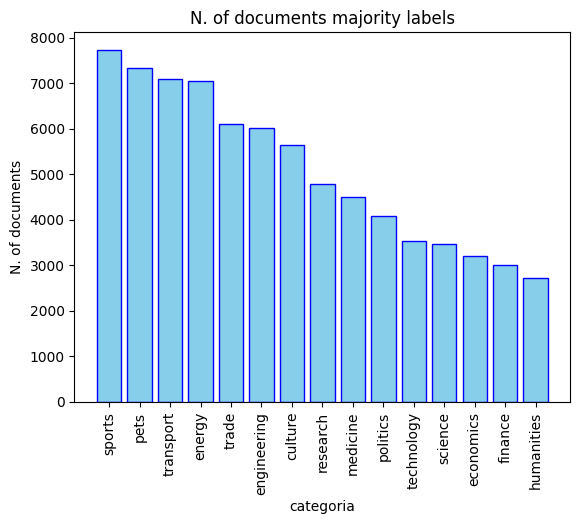

In [ ]:
# visualizing majority label number of documents
n_doc_maj=spark.sql("""SELECT categoria, COUNT(*) AS n_documents
             FROM wiki_restrict
             GROUP BY categoria
             ORDER BY COUNT(*) DESC""")

# to pandas dataframe format
n_doc_maj_pd=n_doc_maj.toPandas()

# plotting documents number distribution
plt.bar(n_doc_maj_pd['categoria'], n_doc_maj_pd['n_documents'], color='skyblue', edgecolor='blue')
plt.xlabel('categoria')
plt.ylabel('N. of documents')
plt.xticks(rotation=90)  # x labels rotation
plt.title("N. of documents majority labels")
plt.show()

Il grafico mostra il numero di documenti per ciascuna classe target maggioritaria selezionata.

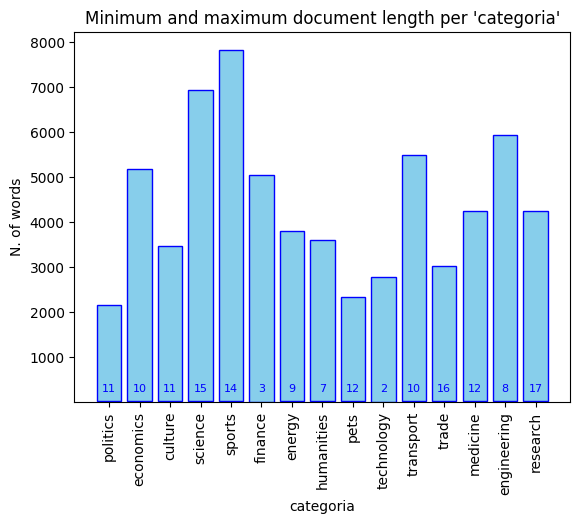

In [ ]:
# max and min document length (in terms of words) for each 'categoria': splitting documents in words and computing
# max and min length
min_max_df=spark.sql("""SELECT categoria, MIN(SIZE(words)) AS len_min_documents, MAX(SIZE(words)) AS len_max_documents
             FROM (SELECT categoria, SPLIT(documents, " ") AS words
                   FROM wiki_restrict
                   WHERE categoria IN ('sports',
                                       'pets',
                                       'transport',
                                       'energy',
                                       'trade',
                                       'engineering',
                                       'culture',
                                       'research',
                                       'medicine',
                                       'politics',
                                       'technology',
                                       'science',
                                       'economics',
                                       'finance',
                                       'humanities'))
             GROUP BY categoria""")

# pandas dataframe format
min_max_df_pd=min_max_df.toPandas()

# min max plot using a bar from len_min to len_max for each 'categoria'
# computing bar height
heights = min_max_df_pd['len_max_documents']-min_max_df_pd['len_min_documents']
# bars start from len_min and reach len_min+heights=len_max
plt.bar(min_max_df_pd['categoria'], heights, bottom=min_max_df_pd['len_min_documents'], color='skyblue', edgecolor='blue')
# adding minimum document length on bars for clarity
for i, min_v in enumerate(min_max_df_pd['len_min_documents']):
    plt.text(i, min_v + 0.05 * max(heights), f'{min_v:d}', ha='center', va='top', fontsize=8, color='blue')

plt.ylabel('N. of words')
plt.xlabel('categoria')
plt.title("Minimum and maximum document length per 'categoria'")
plt.xticks(rotation=90) # x labels rotation
plt.show()


Il grafico mostra la lunghezza minima e massima dei documenti per ciascuna classe target maggioritaria. Per chiarezza, la lunghezza minima è stata esplicitamente sovrascritta sulle barre.
Si nota come alcuni topic presentino documenti di lunghezza dell'ordine delle unità. In questa analisi si tengono tutti i documenti, ma si potrebbe anche valutare e capire se sono dati sbagliati e quindi rimuoverli.

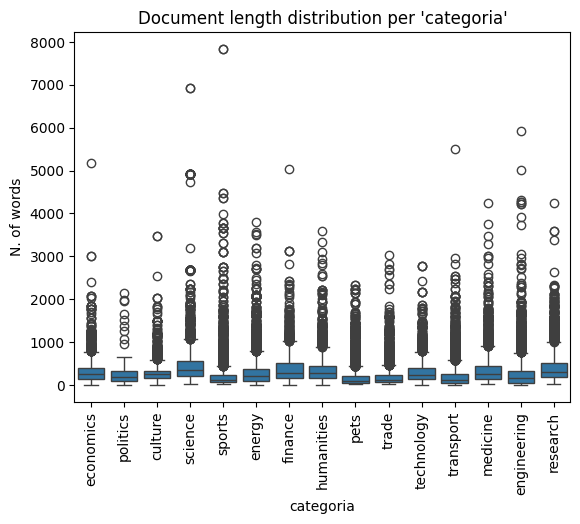

In [ ]:
# box plot document length per 'categoria'
box_df=spark.sql("""SELECT categoria, SIZE(SPLIT(documents, " ")) AS len_documents
                    FROM wiki_restrict
                    WHERE categoria IN ('sports',
                                       'pets',
                                       'transport',
                                       'energy',
                                       'trade',
                                       'engineering',
                                       'culture',
                                       'research',
                                       'medicine',
                                       'politics',
                                       'technology',
                                       'science',
                                       'economics',
                                       'finance',
                                       'humanities')""")

# to pandas dataframe
box_df_pd=box_df.toPandas()

# plot
sns.boxplot(x=box_df_pd['categoria'], y=box_df_pd['len_documents'], data=box_df_pd)
plt.xlabel('categoria')
plt.ylabel('N. of words')
plt.xticks(rotation=90)  # x labels rotation
plt.title("Document length distribution per 'categoria'")
plt.show()

Dal boxplot si può notare come il grafico precedente sulla lunghezza minima e massima dei documenti per ciascuna classe sia ingannevole: infatti i valori di massimo di ciascuna classe sono sempre dovuti ad outliers, mentre la stragrande maggioranza dei testi ha lunghezza dell'ordine delle centinaia di parole, per tutte le classi. Si nota invece come i valori di minimo siano sempre compresi nei baffi del boxplot e siano quindi più rappresentativi (a livello di valore legato alla distribuzione) dei valori di massimo.

##1.3 Nuvole di parole
In questa sezione si identificano le parole maggiormente correlate a ciascun topic adottando due approcci: nel primo ci si basa su un semplice conteggio delle occorrenze di ogni parola in ogni topic, limitandosi alle 30 parole più frequenti. Nel secondo approccio si utilizza una LDA per individuare le parole più legate a ciascun topic.

LDA è un modello probabilistico generativo che si basa sull'assunzione che ogni testo sia una combinazione di vari topic, ognuno dei quali ha associate parole specifiche, sempre in senso probabilistico. LDA cerca quindi di trovare la distribuzione dei topics che meglio giustifica le parole presenti nel testo esaminato, andando infine a rappresentare ogni documento testuale come un vettore denso di lunghezza pari al numero di topic, dove ogni elemento indica la probabilità che quel documento ha di appartenere al dato topic.

Prima di attuare la ricerca delle nuvole di parole, si applicano al dataset alcune attività di preprocessing, tra cui tokenizzazione (preservando solo parole con almeno due caratteri, in ottica informativa) e rimozione delle stopwords, nonché lowercasing.

Poi si divide già il dataset in training e test sets: infatti nella successiva fase di creazione dei modelli di classificazione sarà necessario considerare una unica colonna testuale, risultante dall'unione della colonna con il sommario e il testo di ciascun documento. Tale unione è già applicata anche per permettere l'estrazione di parole ancora più pertinenti per ogni topic, dato che il sommario è generalmente breve e ricco di parole di dominio. Per questo, si sceglie di applicare lo splitting in training e test già in questa fase, analizzando le nuvole di parole solo sul training set, così da evitare anche data leakage nel caso si volessero sfuttare le nuvole di parole per fare predizioni (cosa però non richesta nel presente progetto).

In [ ]:
# lowercasing
columns = ["summary", "documents"]
for c in columns:
    df_restrict = df_restrict.withColumn(f"{c}_lower", lower(col(c)))

# tokenization
tokenizers = []
for c in columns:
    # preserving only tokens with at least two letters
    tokenizer = RegexTokenizer(inputCol=f"{c}_lower", outputCol=f"{c}_words", pattern="[a-z]{2,}", gaps=False)
    tokenizers.append(tokenizer)

# stopwords remotion
stopworders=[]
for c in columns:
    stopwords_remover = StopWordsRemover(inputCol=f"{c}_words", outputCol=f"{c}_filtered_words")
    stopworders.append(stopwords_remover)

# pipeline creation
pipe_eda=Pipeline(stages=tokenizers + stopworders)

###Train/ test split

In [ ]:
# training and test set split
train, test=df_restrict.randomSplit([0.8,0.2], seed=42)
train.createOrReplaceTempView("train") # sql train set tempview

In [ ]:
#checking topic distribution
df_counts=spark.sql("""SELECT categoria, COUNT(*) AS n_documents
                       FROM train
                       GROUP BY categoria
                       ORDER BY COUNT(*) DESC""")
df_counts.show(20, truncate=True)

+-----------+-----------+
|  categoria|n_documents|
+-----------+-----------+
|     sports|       6194|
|       pets|       5893|
|  transport|       5697|
|     energy|       5676|
|      trade|       4863|
|engineering|       4849|
|    culture|       4350|
|   research|       3716|
|   medicine|       3573|
|   politics|       3290|
| technology|       2778|
|    science|       2742|
|  economics|       2587|
|    finance|       2181|
| humanities|       2091|
+-----------+-----------+



In [ ]:
def pipe_activation(pipe, train_set, test_set):
    '''
    The function applies the pipeline to training and test sets.
    Args:
        - pipe (pyspark.Pipeline): the pipeline to apply
        - train_set (pyspark.Dataframe): training set
        - test_set (pyspark.Dataframe): test set
    Returns:
        - (pyspark.PipelineModel): fitted pipeline
        - (pyspark.Dataframe): processed training set
        - (pyspark.Dataframe): processed test set
    '''
    pipe_fit=pipe.fit(train_set) # pipeline fitting on training set

    # pipeline application on training and test sets
    train_set=pipe_fit.transform(train_set)
    test_set=pipe_fit.transform(test_set)

    return pipe_fit, train_set, test_set


In [ ]:
# pipeline fitting and trasformation on training and test sets
_, train_transf, test_transf=pipe_activation(pipe_eda, train, test)

###Unione sommario e testo

In [ ]:
# summary and documents preprocessed cols concatenation to have a single col
train_transf = train_transf.withColumn("all_tokens", concat(col("summary_filtered_words"), col("documents_filtered_words")))
test_transf  = test_transf.withColumn("all_tokens", concat(col("summary_filtered_words"), col("documents_filtered_words")))

### 1.3.1 Nuvole di parole: SQL
Nel primo approccio si deducono nuvole di parole utilizzado SQL, basandosi al conteggio.

In [ ]:
train_transf.createOrReplaceTempView("train_df") # sql tempview

# searching for the 30 most common words for each 'categoria' class (classes are restricted to the maj_categories ones)
train_transf_top_words=spark.sql("""
SELECT categoria, word, occurrences
FROM (
    SELECT categoria, word, occurrences,
           ROW_NUMBER() OVER (PARTITION BY categoria ORDER BY occurrences DESC) AS rn  --for each 'categoria' words are ordered by occurrences
    FROM (
        SELECT categoria, word, COUNT(*) AS occurrences   --counts how many times each word is in each 'categoria' of the exploded data
        FROM (
            SELECT categoria, EXPLODE(all_tokens) AS word   --it takes all_tokens of each row and explode them in rows
            FROM train_df
            WHERE categoria IN ('sports',
                'pets',
                'transport',
                'energy',
                'trade',
                'engineering',
                'culture',
                'research',
                'medicine',
                'politics',
                'technology',
                'science',
                'economics',
                'finance',
                'humanities')
        ) exploded
        GROUP BY categoria, word
    ) counted
) ranked
WHERE rn <= 30 -- only the first 30 words of each 'categoria' are considered
ORDER BY categoria, occurrences DESC""")



# printing each 'categoria' class most common words
for cat in maj_categories: # loop over considered 'categoria' classes
    print(f"Categoria: {cat}")
    df_cat = train_transf_top_words.filter(train_transf_top_words.categoria == cat) # filtering each 'categoria' class
    df_cat.show(30, truncate=False)

Categoria: sports
+---------+-------------+-----------+
|categoria|word         |occurrences|
+---------+-------------+-----------+
|sports   |tennis       |15410      |
|sports   |open         |14480      |
|sports   |singles      |13720      |
|sports   |doubles      |12595      |
|sports   |title        |11517      |
|sports   |polo         |11341      |
|sports   |final        |9700       |
|sports   |won          |9610       |
|sports   |us           |9342       |
|sports   |first        |9316       |
|sports   |tournament   |7725       |
|sports   |player       |7402       |
|sports   |defeated     |7120       |
|sports   |section      |6898       |
|sports   |men          |6424       |
|sports   |round        |6420       |
|sports   |draw         |6247       |
|sports   |women        |6224       |
|sports   |championships|5537       |
|sports   |grand        |5351       |
|sports   |references   |5052       |
|sports   |world        |5046       |
|sports   |slam         |5029   

### 1.3.2 Nuvole di parole: LDA
Nel secondo approccio, si utilizza LDA per ricavare le nuvole di parole. Si setta il numero di topic da ricercare pari al numero di topic filtrati in precedenza dal dataset come più rilevanti. L'inconveniente di usare LDA è che a margine dell'analisi si dovranno etichettare a mano i vari topic trovati.

A differenza delle nuvole create con semplici conteggi, con LDA si considerano per ogni topic le parole con peso maggiore sul dato topic.

In [ ]:
def pipeline_stages(train_set, test_set, with_LDA=False):
    '''
    The function menages pipeline creation from stages definition to fitting on data.
    It allows two stages schemas: one including LDA analysis after a count vectorizer,
    and one without LDA, but using TfIdf.
    Args:
        - train_set (pyspark.Dataframe): training set
        - test_set (pyspark.Dataframe): test set
        - with_LDA (bool): to enable LDA application. Default to False.
    Returns:
        - (pyspark.PipelineModel): fitted pipeline
        - (pyspark.Dataframe): processed training set
        - (pyspark.Dataframe): procesed test set
        - (pyspark.StringIndexerModel): fitted indexer
        - (pyspark.LDAModel): fitted LDA. Optional in base of 'with_LDA' value
        - (list): count vec vocabulary
    '''
    #count vectorizer: filtering tokens present in at least 50 samples and in less than 70% of samples.
    vectorizer = CountVectorizer(inputCol=f"all_tokens", outputCol=f"all_tokens_vectorized", minDF=50, maxDF=0.7)
    # idf
    idf=IDF(inputCol="all_tokens_vectorized", outputCol="all_tokens_tfidf")
    #LDA
    lda = LDA(k=len(maj_categories), # n. of topics to extract
              maxIter=30, # computing steps
              featuresCol="all_tokens_vectorized", # input data
              topicDistributionCol="topicDistribution", # output LDA data
              optimizer="online" # fitting optimization: online is suitable for large datasets
              )

    # target encoding
    indexer = StringIndexer(inputCol="categoria", outputCol="categoriaIndex")

    # pipeline stages
    if with_LDA==True:
        stages=[vectorizer, lda, indexer]
    else: # without lda, using tfidf
        stages=[vectorizer, idf, indexer]

    pipe=Pipeline(stages=stages)

    # pipe fit/transform
    pipe_fit, train_ml, test_ml=pipe_activation(pipe, train_set, test_set)

    # vocab dimension
    vocab = pipe_fit.stages[0].vocabulary
    print(f"Vocabulary dimension: {len(vocab)}")

    # indexer fitted model
    indexer_model=pipe_fit.stages[-1]

    if with_LDA==True:
        # LDA fitted model
        lda_model=pipe_fit.stages[1]
        return pipe_fit, train_ml, test_ml, indexer_model, lda_model, vocab

    return pipe_fit, train_ml, test_ml, indexer_model, vocab

In [ ]:
# pipeline including LDA
pipe, train_lda, test_lda, _, lda_model, vocab_lda=pipeline_stages(train_transf, test_transf, with_LDA=True)

Vocabulary dimension: 13353


In [ ]:
def idx_to_words(indices):
    '''
    The function associates an input indices list to the respective vocabulary words.
    Args:
        - indices (list): input word indices
    Returns:
        - (list): vocabulary words list
    '''
    return [vocab_lda[i] for i in indices]

# idx_to_words function as udf function, in order to be applied to dataframe cols
idx_to_words_udf = udf(idx_to_words, ArrayType(StringType()))


In [ ]:
# extracting word clouds from LDA in terms of indices
topics = lda_model.describeTopics(maxTermsPerTopic=30)

# adding a new col with words list for each topic, thus converting indices in words
topics_words = topics.withColumn("words", idx_to_words_udf("termIndices"))

# joining element by element word and topic weights, to have (topic, word, weight),
# using a struct to arrange multiple cols in a single structured col.
topics_words_struct = topics_words.select(
                      "topic",
                      explode(arrays_zip(     # arranging words and weights together in pairs for each topic, to have (topic, word, weight)
                         col("words").alias("word"),
                         col("termWeights").alias("weight"))).alias("tw")
                      ).select(col("topic"),
                               col("tw.word").alias("word"),
                               col("tw.weight").alias("weight"))


topics_words_struct.createOrReplaceTempView("topics_words_table") # sql tempview

# distinct topic list
topic_indices = [row['topic'] for row in topics_words_struct.select("topic").distinct().orderBy("topic").collect()]

# loop over topic indices to print each topic's most related words
for idx in topic_indices:
    print(f"Topic {idx}:")
    spark.sql(f"""SELECT word, ROUND(weight, 3) AS weight
              FROM topics_words_table
              WHERE topic = {idx}
              ORDER BY weight DESC""").show(30, truncate=False)

Topic 0:
+---------+------+
|word     |weight|
+---------+------+
|station  |0.036 |
|line     |0.017 |
|railway  |0.012 |
|greyhound|0.01  |
|stadium  |0.009 |
|racing   |0.008 |
|located  |0.007 |
|opened   |0.007 |
|track    |0.007 |
|road     |0.006 |
|services |0.005 |
|new      |0.005 |
|two      |0.005 |
|also     |0.005 |
|first    |0.004 |
|south    |0.004 |
|one      |0.004 |
|airport  |0.004 |
|platform |0.004 |
|city     |0.004 |
|de       |0.004 |
|street   |0.004 |
|metro    |0.004 |
|north    |0.004 |
|bus      |0.004 |
|part     |0.004 |
|west     |0.004 |
|year     |0.003 |
|trains   |0.003 |
|race     |0.003 |
+---------+------+

Topic 1:
+-----------+------+
|word       |weight|
+-----------+------+
|species    |0.04  |
|fish       |0.015 |
|lake       |0.013 |
|found      |0.012 |
|cichlid    |0.012 |
|length     |0.011 |
|genus      |0.011 |
|endemic    |0.01  |
|also       |0.01  |
|centimetres|0.008 |
|reach      |0.007 |
|galaxy     |0.007 |
|samsung    |0.007 |

Come anticipato, le nuvole di parole dedotte da LDA non sono automaticamente associate ai topic, per questo si associano manualmente:
- 0: transport
- 1: pets
- 2: sports
- 3: science
- 4: finance
- 5: technology
- 6: humanities
- 7: economics
- 8: engineering
- 9: medicine
- 10: trade
- 11: politics
- 12: energy
- 13: research
- 14: culture

Di queste associazioni manuali, alcune si notano essere abbastanza chiare e deducibili anche tramite le nuvole generate senza LDA. Altre invece risultano più ambigue e incerte, come si può osservare dalle nuvole di parole stesse.

Inoltre, le nuvole di parole riflettono anche la somiglianza tra alcuni topic: infatti in alcune coppie di topic le parole presenti sono simili e spesso ugualmente presenti. Questo implica come i rispettivi topic siano vicini semanticamente e logicamente, e questo può portare i modelli di classificazione a non capire bene quale sia il topic adeguato, come vedremo.

#**2. Modelli di classificazione**
In questa sezione si creano modelli di classificazione per automatizzare l'etichettatura di ciascun documento con il topic adeguato. Si approntano due tipi di modelli: due modelli Random Forest, differenti nel preprocessing del dato testuale, e un modello a rete neurale MLP. Tutti i modelli sono valutati tramite l'uso di metriche adeguate come precision, recall, matrice di confusione.
##2.1 Bilanciamento dataset
Prima di addestrare modelli di classificazione, si è già notato in precedenza come il dataset ristretto alle sole classi target prevalenti sia comunque sbilanciato, anche se non in maniera eccessiva. Per consentire un training efficace, si sceglie di sottocampionare le varie classi target in modo che tutte abbiano un numero di dati pari a quelli della classe che ne ha di meno. Per questo si sottocampionano le varie classi in modo randomico sui dati di ognuna di esse, andando infine a riunire tutti i dati così estratti in un unico dataset finale, che sarà l'input per il training dei modelli di classificazione.

In [ ]:
# n of samples per each target class
class_counts=train_transf.groupBy("categoria").count().collect()
# minimum number of samples in target classes
min_count = min(row['count'] for row in class_counts)

# for each class a sample of size min_count is extracted
samples = [] # list of dataframes to store the undersampled data (a dataframe per class)
for row in class_counts:
    c = row['categoria'] #
    frac = min_count / row['count']  # fraction to extract
    # randomly sampling the given class samples without repetitions
    sample_c = train_transf.filter(train_transf.categoria == c).sample(withReplacement=False, fraction=frac)
    samples.append(sample_c)

# Merging the 'samples' list of dataframe into a single one
balanced_train = samples[0] # firt dataframe of the 'samples' list
for s in samples[1:]:
    balanced_train = balanced_train.union(s)

In [ ]:
#checking topic distribution after balancing
balanced_train.createOrReplaceTempView('balanced_train') # sql tempview
spark.sql("""SELECT categoria, COUNT(*) AS n_documenti
             FROM balanced_train
             GROUP BY categoria
             ORDER BY COUNT(*) DESC""").show(20, truncate=True)

+-----------+-----------+
|  categoria|n_documenti|
+-----------+-----------+
|engineering|       2163|
|      trade|       2136|
|   medicine|       2116|
| technology|       2113|
|    science|       2099|
|    finance|       2098|
|  economics|       2094|
|    culture|       2091|
| humanities|       2091|
|     energy|       2085|
|       pets|       2073|
|   politics|       2071|
|  transport|       2049|
|   research|       2038|
|     sports|       2032|
+-----------+-----------+



##2.2 Random forest
Il primo modello di classificazione che si implementa è una Random Forest. Questo modello sarà allenato sia con dati in input su cui è applicata LDA, sia su dati input processati con TfIdf, cercando di capire se un preprocessing diverso possa portare a conseguenze diverse, specie assumendo più adeguata e ragionata la rappresentazione di LDA: infatti oltre ad avere una rappresentazione che viene raffinata nelle varie iterazioni, LDA porta anche a rappresentare ogni documento come un vettore denso lungo quanto il numero di topic, ottenendo quindi una rappresentazione più compatta e computazionalmente leggera rispetto a TfIdf, che invece per ciascun documento genera un vettore di lunghezza pari a quella del vocabolario.

Inoltre, per selezionare al meglio gli iperparametri della Random Forest, si applica una gridsearch su valori prestabiliti degli iperparametri. Al termine della ricerca, il modello migliore viene riallenato di default su tutto il set di training in input. C'è da considerare che utilizzando Spark in locale non si trae vantaggio dal calcolo distribuito e questo si riflette sull'impossibilità di testare valori degli iperparametri troppo elevati o numerosi, proprio per limitate risorse computazionali.   

In [ ]:
def label_predictions(indexer_model, predictions):
    '''
    The function associates to each predicted class id, the explicit class name, to better visualize predictions.
    Args:
        - indexer_model (pyspark.StringIndexerModel): fitted indexer used in the train/test preprocessing
        - predictions (pyspark.Dataframe): dataframe storing train or test original dataframes, added with a col storing model predictions.
    '''
    # class id to class name convertion
    converter = IndexToString(
        inputCol="prediction", # class id
        outputCol="predicted_categoria", # class name
        labels=indexer_model.labels # class-id list
    )
    # computing predicted class names
    predictions_with_labels = converter.transform(predictions)
    # showing true and predicted classes
    predictions_with_labels.select("categoria", "predicted_categoria").show(10)


def metrics_evaluator(indexer_model, predictions):
    '''
    The function performs several evaluation methods on a given model predictions:
    computes metrics and shows confusion matrix and model predictions.
    Args:
        - indexer_model (pyspark.StringIndexerModel): fitted indexer used in train/test prerpocessing
        - predictions (pyspark.Dataframe): dataframe storing train or test original dataframes, added with a col storing model predictions.
    '''
    # metrics computation
    metric_list=['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
    for metric_name in metric_list:
        # multiclass evaluator instatiation for the given metric
        evaluator = MulticlassClassificationEvaluator(labelCol="categoriaIndex",
                                                      predictionCol="prediction",
                                                      metricName=metric_name)
        # evaluator application to compute the metric
        metric_value = evaluator.evaluate(predictions)
        print(f"{metric_name}: {metric_value:.3f}")

    # confusion matrix
    print("\nConfusion matrix:")
    # extraction of (prediction, categoriaIndex) tuple
    predictionAndLabels = predictions.select("prediction", "categoriaIndex").rdd.map(lambda row: (row[0], row[1]))
    # MulticlassMetrics instantiation
    metrics = MulticlassMetrics(predictionAndLabels)
    # confusion matrix as np array
    conf_matrix=metrics.confusionMatrix().toArray()

    #label names from indices for confusion matrix
    labels_names = indexer_model.labels
    conf_matrix_df = pd.DataFrame(conf_matrix, index=labels_names, columns=labels_names)

    # confusion matrix heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(conf_matrix_df, annot=True,  fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # explicit label predictions
    print('Label Predictions')
    label_predictions(indexer_model, predictions)


def model_evaluation(model, train_set, test_set, indexer_model):
    '''
    The function evaluates the input model performances,
    computing model predictions and invoking the metrics_evaluator function.
    Args:
        - model (pyspark.LogisticRegressionModel or pyspark.MultilayerPerceptronClassifierModel): fitted classifcation model to evaluate
        - train_set (pyspark.Dataframe): training set
        - test_set (pyspark.Dataframe): test set
        - indexer_model (pyspark.StringIndexerModel): fitted indexer used in the train/test preprocessing
    '''
    # model predictions
    train_predictions= model.transform(train_set)
    test_predictions = model.transform(test_set)

    # metrics analysis
    print('TRAIN predictions:')
    metrics_evaluator(indexer_model, train_predictions)
    print('\n\nTEST predictions:')
    metrics_evaluator(indexer_model, test_predictions)


In [ ]:
def rf_building(train_set, training_col, name_path):
    '''
    The function finds the best random forest model varying hyperparameters, selecting the model with highest f1 score.
    Hyperparameters are the number of trees and maxDepth. They are tested using gridsearch.
    Args:
        - train_set (pyspark.Dataframe):
        - training_col (str): name of the input dataframe col to use as input for training the random forest
        - name_path (str): name to insert for file saving
    Returns:
        - (pyspark.RandomForestClassificationModel): best model extracted using gridsearch
    '''
    # random forest model
    rf = RandomForestClassifier(featuresCol=training_col, labelCol="categoriaIndex")

    # Hyperparameter grid
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [3, 5]).addGrid(rf.maxDepth, [12, 20]).build()

    # evaluation metric (on validation set)
    metric_name='f1'
    evaluator = MulticlassClassificationEvaluator(labelCol="categoriaIndex", predictionCol="prediction", metricName=metric_name)

    # Model validation using train/validation split
    tvs = TrainValidationSplit(estimator=rf, # random forest model as estimator
                               estimatorParamMaps=paramGrid,
                               evaluator=evaluator,
                               trainRatio=0.8  # 80% train, 20% validation
                              )

    # dataframe reduction to essential training columns, to avoid RAM saturation
    train_set_reduced = train_set.select(training_col, "categoriaIndex")


    # model fit to find the best hyperparameters combination
    tvs_fit=tvs.fit(train_set_reduced)
    metrics = tvs_fit.validationMetrics
    best_metric = max(metrics)
    print("BEST MODEL ANALYSIS:")
    print(f"Best {metric_name}: {best_metric:.4f}")

    # best model extraction
    best_model = tvs_fit.bestModel

    # selected hyperparameters
    print("Best Num Trees:", best_model.getOrDefault("numTrees"))
    print("Best Max Depth:", best_model.getOrDefault("maxDepth"))
    print('-----------------------------------------------------')
    # saving best model
    best_model.write().overwrite().save(f"/content/drive/MyDrive/big data/best_random_forest_{name_path}")
    return best_model

#2.2.1 Random Forest con LDA
In questo primo modello Random Forest, si utilizza LDA per preprocessare il dato testuale prima di darlo in input al modello.

In [ ]:
# pipeline with LDA for ML model
pipe, train_ml, test_ml, indexer_model_lda, lda_model, vocab=pipeline_stages(balanced_train, test_transf, with_LDA=True)

Vocabulary dimension: 8965


BEST MODEL ANALYSIS:
Best f1: 0.7735
Best Num Trees: 5
Best Max Depth: 20
-----------------------------------------------------
TRAIN predictions:
weightedPrecision: 0.903
weightedRecall: 0.899
accuracy: 0.899
f1: 0.899

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


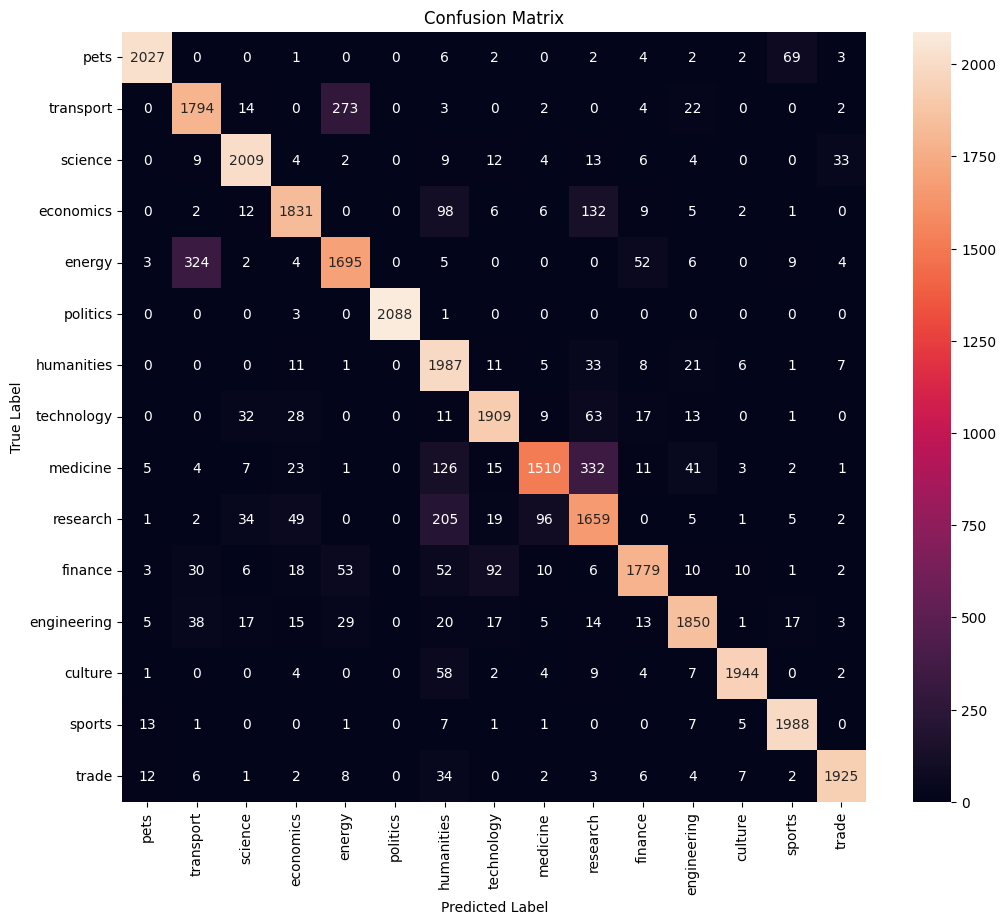

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
+---------+-------------------+
only showing top 10 rows


TEST predictions:
weightedPrecision: 0.807
weightedRecall: 0.799
accuracy: 0.799
f1: 0.800

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


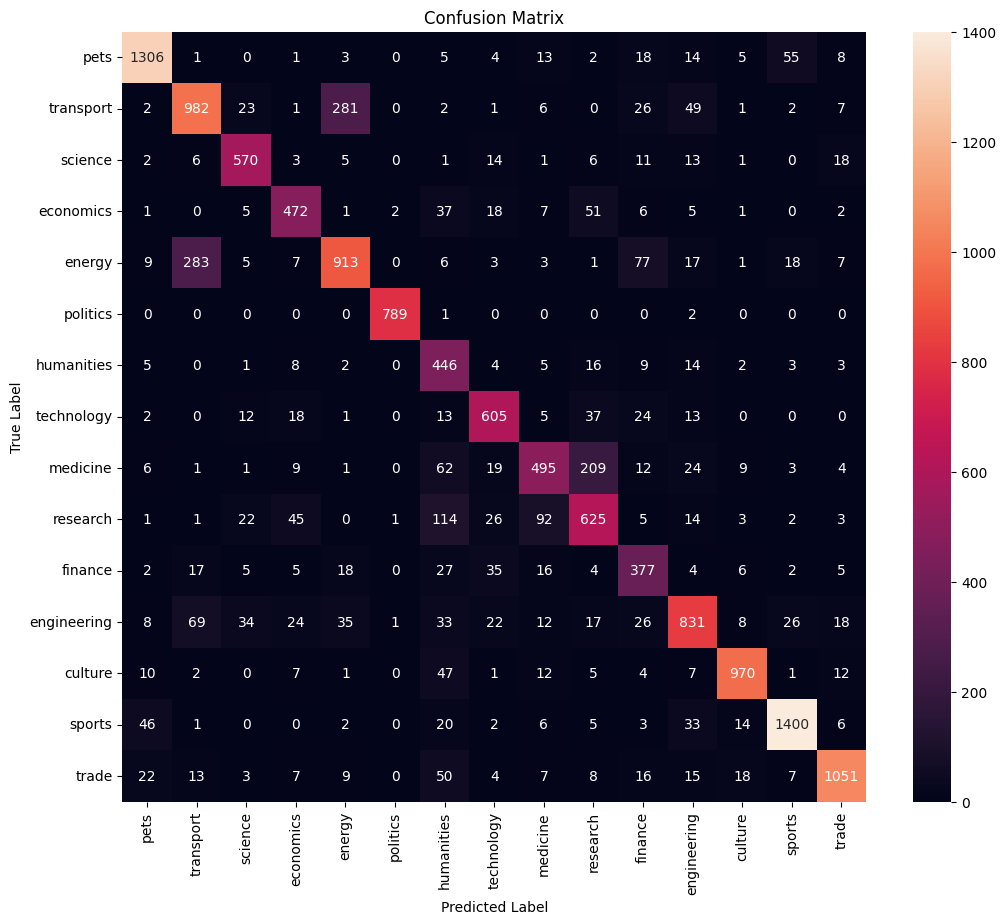

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
|economics|          economics|
|economics|           medicine|
|economics|          economics|
|economics|           research|
|economics|           research|
|economics|          economics|
|economics|          economics|
| politics|        engineering|
|economics|          economics|
|economics|           research|
+---------+-------------------+
only showing top 10 rows


In [ ]:
# model fitting
rf_lda_model=rf_building(train_ml, training_col="topicDistribution", name_path='LDA')
# evaluation
model_evaluation(rf_lda_model, train_ml, test_ml, indexer_model_lda)





Si nota come il modello addestrato con LDA sia efficace in linea generale. Si nota però la presenza di overfitting, in quanto le performance tra set di training e test sono lievemente diverse a discapito del set di test. Questo può essere sicuramente mitigato andando ad aumentare il numero di alberi del modello: infatti avere più alberi ha proprio lo scopo di mitigare l'overfiting e aiutare il modello a generalizzare. Tale miglioria però risulta non fattibile in locale proprio per le limitate risorse computazionali menzionate prima.

Dalla confusion matrix sul set di test si nota come il modello tenda a confondere soprattutto le classi 'transport' e 'energy', oppure 'medicine' e 'research'. Questi errori sono in realtà comprensibili già dalle nuvole di parole estratte in precedenza, dove si poteva notare come ambiti diversi avessero liste di parole simili tra loro.

#2.2.2 Random Forest con TfIdf
In questo secondo approccio, il modello Random Forest è addestrato su dati testuali codificati tramite TfIdf, che assegna ad ogni parola un peso che dipende sia dalla frequenza della parola nel documento in esame, sia da quanto la parola è rara nell'intero corpus di documenti. Questa procedura aiuta a ridurre il peso associato alle parole più frequenti e quindi poco discriminanti.

In [ ]:
# pipeline with Tfidf
pipe_tfidf, train_tfidf, test_tfidf, indexer_model_tfidf, vocab_tfidf = pipeline_stages(balanced_train, test_transf, with_LDA=False)

Vocabulary dimension: 8965


BEST MODEL ANALYSIS:
Best f1: 0.7602
Best Num Trees: 5
Best Max Depth: 20
-----------------------------------------------------
TRAIN predictions:
weightedPrecision: 0.831
weightedRecall: 0.799
accuracy: 0.799
f1: 0.809

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


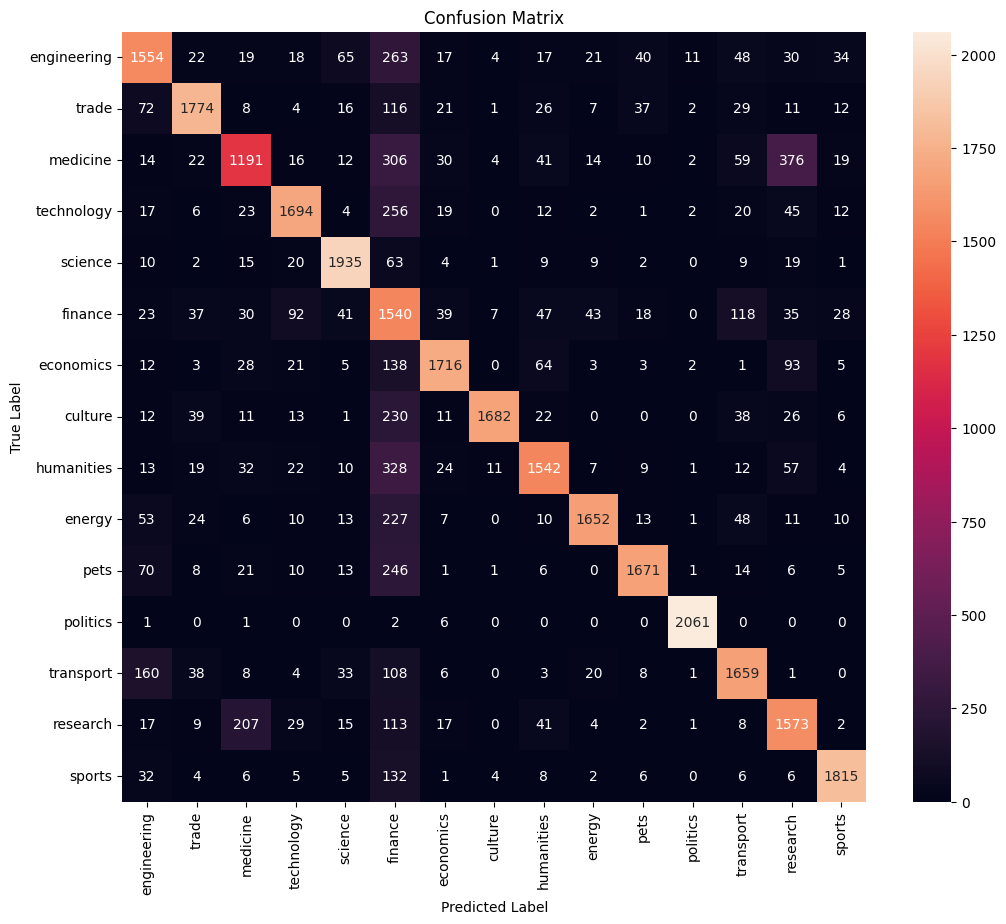

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
| politics|          economics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
+---------+-------------------+
only showing top 10 rows


TEST predictions:
weightedPrecision: 0.811
weightedRecall: 0.761
accuracy: 0.761
f1: 0.779

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


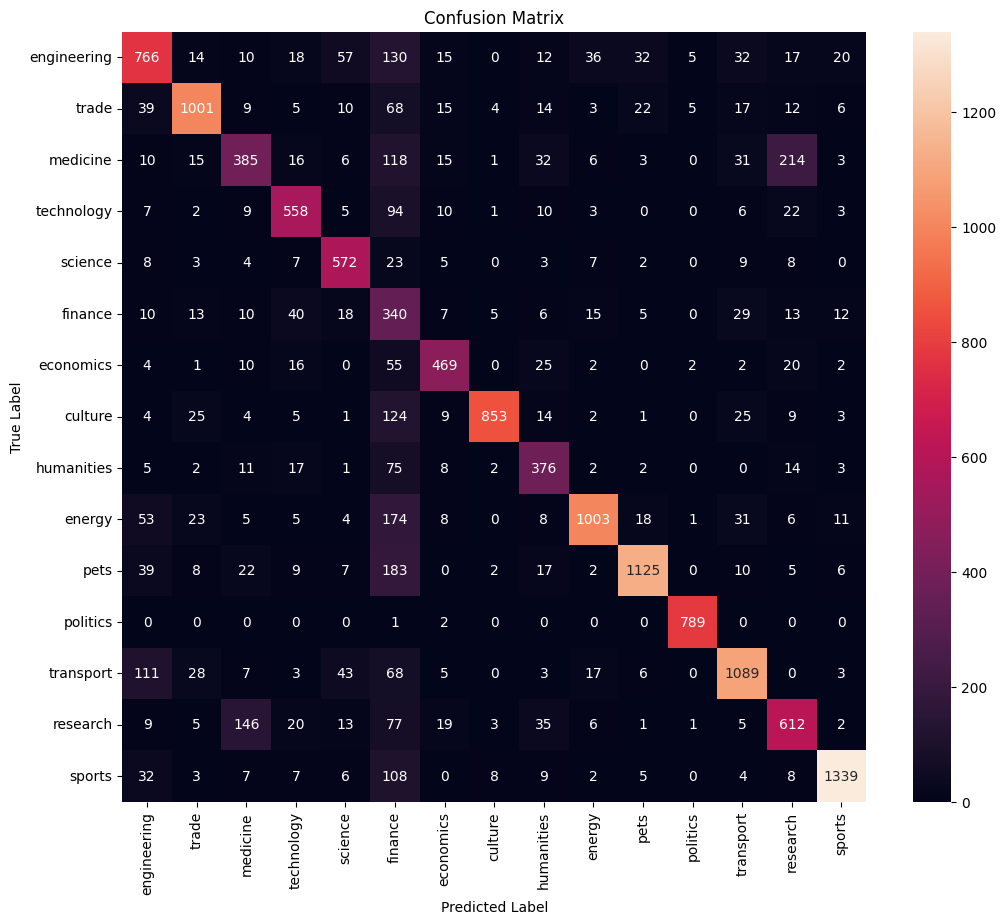

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
|economics|         humanities|
|economics|             sports|
|economics|         humanities|
|economics|            finance|
|economics|          economics|
|economics|          economics|
|economics|            finance|
| politics|          economics|
|economics|              trade|
|economics|          economics|
+---------+-------------------+
only showing top 10 rows


In [ ]:
# model fitting
rf_tfidf_model=rf_building(train_tfidf, training_col="all_tokens_tfidf", name_path='TFIDF')
# evaluation
model_evaluation(rf_tfidf_model, train_tfidf, test_tfidf, indexer_model_tfidf)

In questo secondo approccio, aver cambiato il preprocessing porta ad un modello meno tendente all'overfitting. Il valore degli iperparametri selezionati dalla gridsearch è lo stesso del modello precedente. Come già menzionato, sicuramente incrementare il numero di alberi porterebbe a ridurre ulteriormente l'overfitting. In generale, di pari passo con l'aumento degli alberi, si potrebbe anche provare ad aumentare la profondità di ciascun albero, avendo così un modello ancora più performante, tenendo a bada l'overfitting.

Dalla matrice di confusione sul set di test si nota come questo secondo modello tenda di più a sbagliare predizione, in generale. Le classi su cui tende di più a confondersi sono ancora una volta 'medicine' e 'research', e poi 'finance' e 'pets'. In generale, si può dire che il modello con LDA a parità di struttura di random forest, pur inducendo maggior overfitting, tende comunque a classificare meglio sul set di test, ma la veridicità di questa conclusione è sempre governata dalla limitatezza dalle risorse computazionali.

##2.3 MLP
L'ultimo modello testato è un modello a reti neurali, nella forma di un multilayer perceptron. La struttura a rete neurale è più adatta a catturare relazioni nonlineari tra i dati rispetto ad un albero decisionale, inoltre la rete può apprendere in autonomia rappresentazioni complesse dei dati di input, che la rendono più efficace nell'identificare la classe più adatta.

In pyspark i nodi dell'MLP prevedono una funzione di attivazione sigmoide per strati nascosti e softmax per strato di output, nel caso di classificazione multiclasse.
Per addestrare l'MLP, si adotta la codifica TfIdf per il testo, in quanto mantiene più informazioni e avendo a disposizione molti dati, la rete può avere modo di apprendere relazioni complesse in autonomia.

In [ ]:
# list of layers with a given n. of nodes
layers = [len(vocab_tfidf), 50, 20, 15]
# MLP
mlp = MultilayerPerceptronClassifier(featuresCol="all_tokens_tfidf", # features to train model
                                     labelCol="categoriaIndex", # target classes
                                     maxIter=10, # epochs
                                     layers=layers, # structure of the MLP
                                     blockSize=64, # batch size
                                     seed=42)

# dataframe reduction to essential training columns for RAM needs
train_set_reduced = train_tfidf.select('all_tokens_tfidf', "categoriaIndex")


# model fit
mlp_fit=mlp.fit(train_set_reduced)

mlp_fit.write().overwrite().save(f"/content/drive/MyDrive/big data/MLP_TFIDF")


TRAIN predictions:
weightedPrecision: 0.932
weightedRecall: 0.932
accuracy: 0.932
f1: 0.932

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


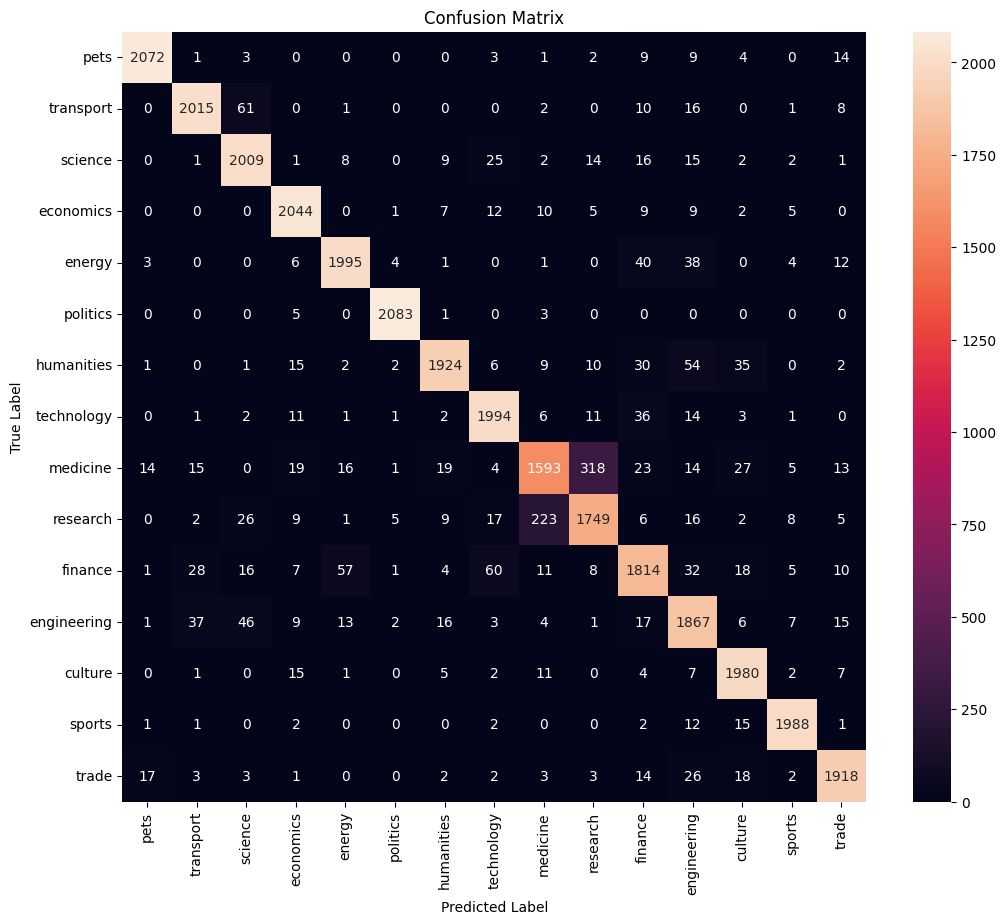

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
| politics|          economics|
| politics|           politics|
| politics|          economics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
| politics|           politics|
+---------+-------------------+
only showing top 10 rows


TEST predictions:
weightedPrecision: 0.921
weightedRecall: 0.920
accuracy: 0.920
f1: 0.920

Confusion matrix:


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


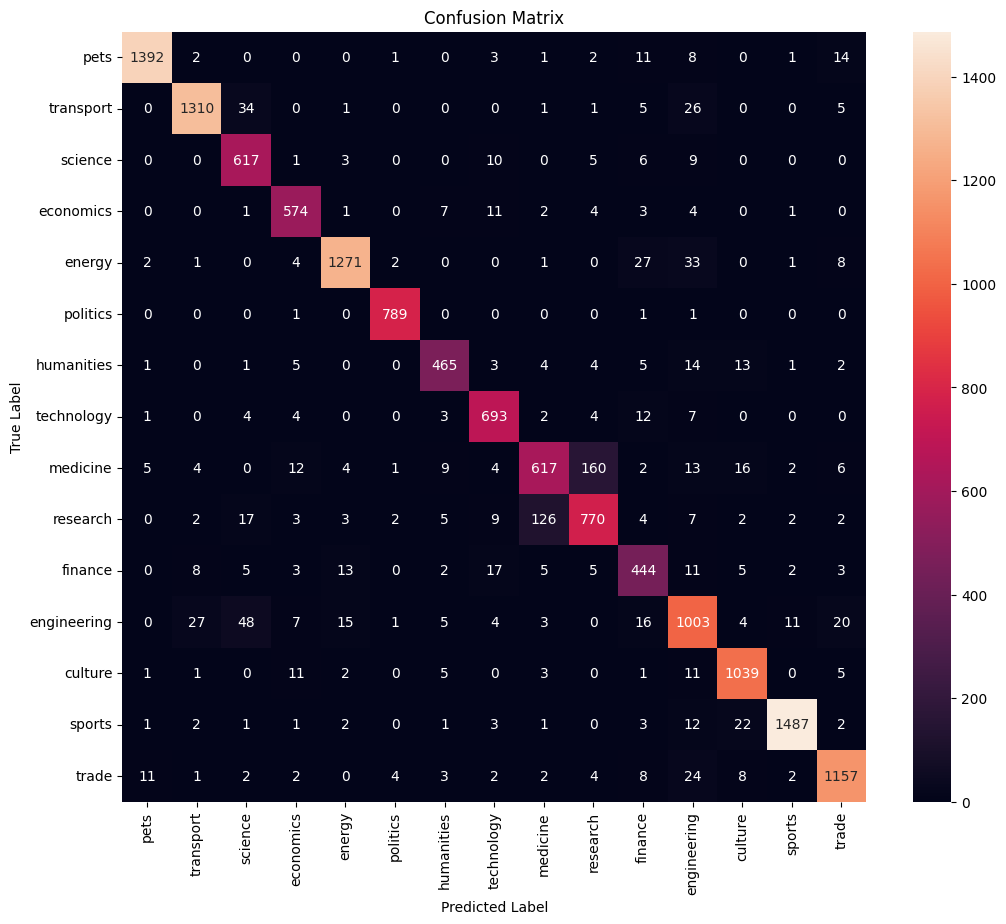

Label Predictions
+---------+-------------------+
|categoria|predicted_categoria|
+---------+-------------------+
|economics|          economics|
|economics|           research|
|economics|          economics|
|economics|          economics|
|economics|          economics|
|economics|          economics|
|economics|          economics|
| politics|          economics|
|economics|          economics|
|economics|          economics|
+---------+-------------------+
only showing top 10 rows


In [ ]:
# MLP evaluation
model_evaluation(mlp_fit, train_tfidf, test_tfidf, indexer_model_tfidf)

In questo ultimo modello, si ottengono prestazioni molto elevate sia su training che su test set, risultando nel modello più adeguato al task. Questo è però anche dovuto alla limitatezza computazionale che non consente di testare ad hoc la random forest. Tornando al modello in esame, si nota come anche questo modello tenda a confondere le classi 'medicine' e 'research'. Questo porta a considerare come avere un dato di base adeguato sia molto importante: in questo caso i due ambiti sono molto simili e usano terminologia simile, portando ad essere facilmente fraintesi. Con la rete neurale però, il grado di confusione è molto minore rispetto ai casi precedenti.

#**3. Conclusioni**
In questo progetto realizzato adottando Spark, si è affrontata l'analisi dei documenti presenti in Wikipedia. L'analisi ha compreso una prima indagine esplorativa dei documenti, seguita dall' individuazione delle parole più comuni/tipiche per ogni dato topic, sia basandosi sulle occorrenze sia utilizzando LDA, passando infine a realizzare modelli di classificazione del topic, utilizzando random forest e reti neurali. Dalla creazione dei modelli, si è notato come modelli basati sul preprocessing fatto tramite LDA siano più adatti ad individuare la giusta classe del documento considerato rispetto al preprocessing con TfIdf. D'altro canto, l'utilizzo di preprocessing TfIdf in combinazione con una rete neurale è risultato essere l'approccio migliore in generale. Queste performance non sono però definitive, in quanto legate all'uso locale di Spark, e quindi alle limitate risorse computazionali disponibili.